In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import os
import shutil

import numpy as np 
import pandas as pd

import pydicom as dicom
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
train_dir = Path('E:\data\RSNA2024')

class CFG:
    random_seed = 42
    
    ROOT_FOLDER = train_dir
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    FILES_CSV = ROOT_FOLDER / 'train_files.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'



In [4]:
train_df = pd.read_csv(CFG.TRAIN_CSV)
train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)

coords_df = pd.read_csv(CFG.COORDS_CSV)
files_df = pd.read_csv(CFG.FILES_CSV)

coords_df.shape, files_df.shape, train_df.shape, train_desc_df.shape

((48692, 18), (147218, 21), (1975, 26), (6294, 3))

In [5]:
coords_df.sample(2)

study_id   series_id  instance condition level           x  \
37780  3328458132  1512137966        28       LSS  L1L2  275.303138   
19926  1778251850  3681929374        13      RNFN  L1L2  139.704315   

                y                  ss_id               instance_id        cl  \
37780  351.065456  3328458132_1512137966  3328458132_1512137966_28   LSSL1L2   
19926   75.069521  1778251850_3681929374  1778251850_3681929374_13  RNFNL1L2   

      series_description  rows  columns  \
37780           Axial T2   512      512   
19926        Sagittal T1   256      256   

                                                filename patientposition  \
37780  E:\data\RSNA2024\pngs_256\3328458132_151213796...             HFS   
19926  E:\data\RSNA2024\pngs_256\1778251850_368192937...             HFS   

         x_perc    y_perc  inst_perc  
37780  0.537701  0.685675   0.675000  
19926  0.545720  0.293240   0.705882

### Filter bad labels

In [6]:
bad_labels = [3819260179, 2444340715] + coords_df[coords_df['x'] < 10].study_id.tolist()

print(bad_labels), len(bad_labels)

[3819260179, 2444340715, 38281420, 286903519, 665627263, 1438760543, 1510451897, 1820866003, 1880970480, 1901348744, 2151467507, 2151509334, 2316015842, 2444340715, 2905025904]


(None, 15)

In [7]:
clean_coords_df = coords_df[~coords_df['study_id'].isin(bad_labels)]

coords_df.shape, clean_coords_df.shape

((48692, 18), (48350, 18))

### Images per plane

In [8]:
coords_df.groupby(['series_description','study_id']).instance.nunique().groupby(['series_description']).agg(['min', 'max', 'mean'])

min  max      mean
series_description                    
Axial T2              2   10  6.847518
Sagittal T1           1   10  4.199797
Sagittal T2/STIR      1    5  1.277750

In [9]:
coords_df.groupby(['series_description','study_id']).instance.nunique().groupby(['series_description']).max()

series_description
Axial T2            10
Sagittal T1         10
Sagittal T2/STIR     5
Name: instance, dtype: int64

### Condition positions limits

In [10]:
clean_coords_df.groupby('series_description').agg({'x_perc': ['min', 'max'],'y_perc': ['min', 'max']})

x_perc              y_perc          
                         min       max       min       max
series_description                                        
Axial T2            0.284956  0.663196  0.309262  0.807810
Sagittal T1         0.208464  0.768467  0.107511  0.882793
Sagittal T2/STIR    0.106874  0.768142  0.141429  0.876847

In [69]:
clean_coords_df.groupby('series_description').agg({'inst_perc': ['min', 'max', 'mean']})

inst_perc                    
                         min       max      mean
series_description                              
Axial T2                 0.0  0.999208  0.498744
Sagittal T1              0.0  0.952381  0.458251
Sagittal T2/STIR         0.0  0.904762  0.469828

In [12]:
coords_df.iloc[coords_df['y_perc'].argmin()]

study_id                                                     1820866003
series_id                                                     131094096
instance                                                              7
condition                                                           SCS
level                                                              L2L3
x                                                                   5.0
y                                                              2.063098
ss_id                                              1820866003_131094096
instance_id                                      1820866003_131094096_7
cl                                                              SCSL2L3
series_description                                     Sagittal T2/STIR
rows                                                                512
columns                                                             512
filename              E:\data\RSNA2024\pngs_256\1820866003_13109

### Plot conditions

In [13]:
row = coords_df.iloc[coords_df['y_perc'].argmin()]

row['level']

'L2L3'

In [14]:
coords_df.groupby(['study_id', 'condition']).instance_id.count().mean()

4.9353334684776

In [15]:
def plot(row, source=CFG.IMAGES_DIR):
    # filename = row['filename']

    filename = source / str(row['study_id']) / str(row['series_id']) / f'{row["instance"]}.dcm'

    conds = coords_df[coords_df['ss_id'] == row['ss_id']]

    print(row['study_id'])
    print(conds.x.to_list())
    print(conds.cl.to_list())
    print(conds.y.to_list())
    
    ds = dicom.dcmread(filename)
    img = ds.pixel_array

    # img = (img - img.min()) / (img.max() - img.min())

    if ds.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    plt.imshow(img, cmap="gray")
    
    # plt.scatter(row['x'], row['y'], marker="x", color="red", s=200)

    plt.title(row['series_description'] + f' - {row["instance"]}')

    plt.scatter(conds.x.to_list(), conds.y.to_list(), marker="x", color="red", s=200)
    
    plt.show()

In [16]:
coords_df.sample(2)

study_id  series_id  instance condition level           x  \
18547  1666601651  871909401         4       LSS  L1L2  181.735849   
13054  1165361924  713083903        10      LNFN  L3L4  192.000000   

                y                 ss_id              instance_id        cl  \
18547  172.981132  1666601651_871909401   1666601651_871909401_4   LSSL1L2   
13054  148.827324  1165361924_713083903  1165361924_713083903_10  LNFNL3L4   

      series_description  rows  columns  \
18547           Axial T2   320      320   
13054        Sagittal T1   384      384   

                                                filename patientposition  \
18547  E:\data\RSNA2024\pngs_256\1666601651_871909401...             HFS   
13054  E:\data\RSNA2024\pngs_256\1165361924_713083903...             HFS   

         x_perc    y_perc  inst_perc  
18547  0.567925  0.540566       0.12  
13054  0.500000  0.387571       0.60

In [17]:
def plot_conditions(study_id, source=CFG.IMAGES_DIR):
    df = coords_df[coords_df['study_id'] == study_id].sort_values(by='series_description', ascending=False)

    ss_ids = df.instance_id.unique()
    imgs = dict(zip(ss_ids, [{'points':[], 'labels':[]} for i in ss_ids]))

    for i in df.instance_id.unique():
        sel = df[df['instance_id'] == i]

        row = sel.iloc[0]
        imgs[i]['filename'] = source / str(row['study_id']) / str(row['series_id']) / f'{row["instance"]}.dcm'
        imgs[i]['title'] = ('-').join([row.series_description] + sel.condition.unique().tolist())

        for index, row in sel.iterrows():
            imgs[i]['points'].append((row.x, row.y, row.condition))

    rows = len(imgs.keys()) // 4 + 1
    fig, axs = plt.subplots(rows, 4, figsize=(15, rows*3))

    fig.suptitle(study_id)

    axs = axs.flat

    for i, (key, value) in enumerate(imgs.items()):
        ax = axs[i]

        ax.margins(0, 0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.title.set_text(value['title'])
        
        ds = dicom.dcmread(value['filename'])
        img = ds.pixel_array

        # img = (img - img.min()) / (img.max() - img.min())

        if ds.PhotometricInterpretation == "MONOCHROME1":
            img = 1 - img

        ax.imshow(img, cmap="gray")

        for p in value['points']:
            ax.scatter(p[0], p[1], label=p[2], marker="x", color="red", s=200)
    
    plt.show()

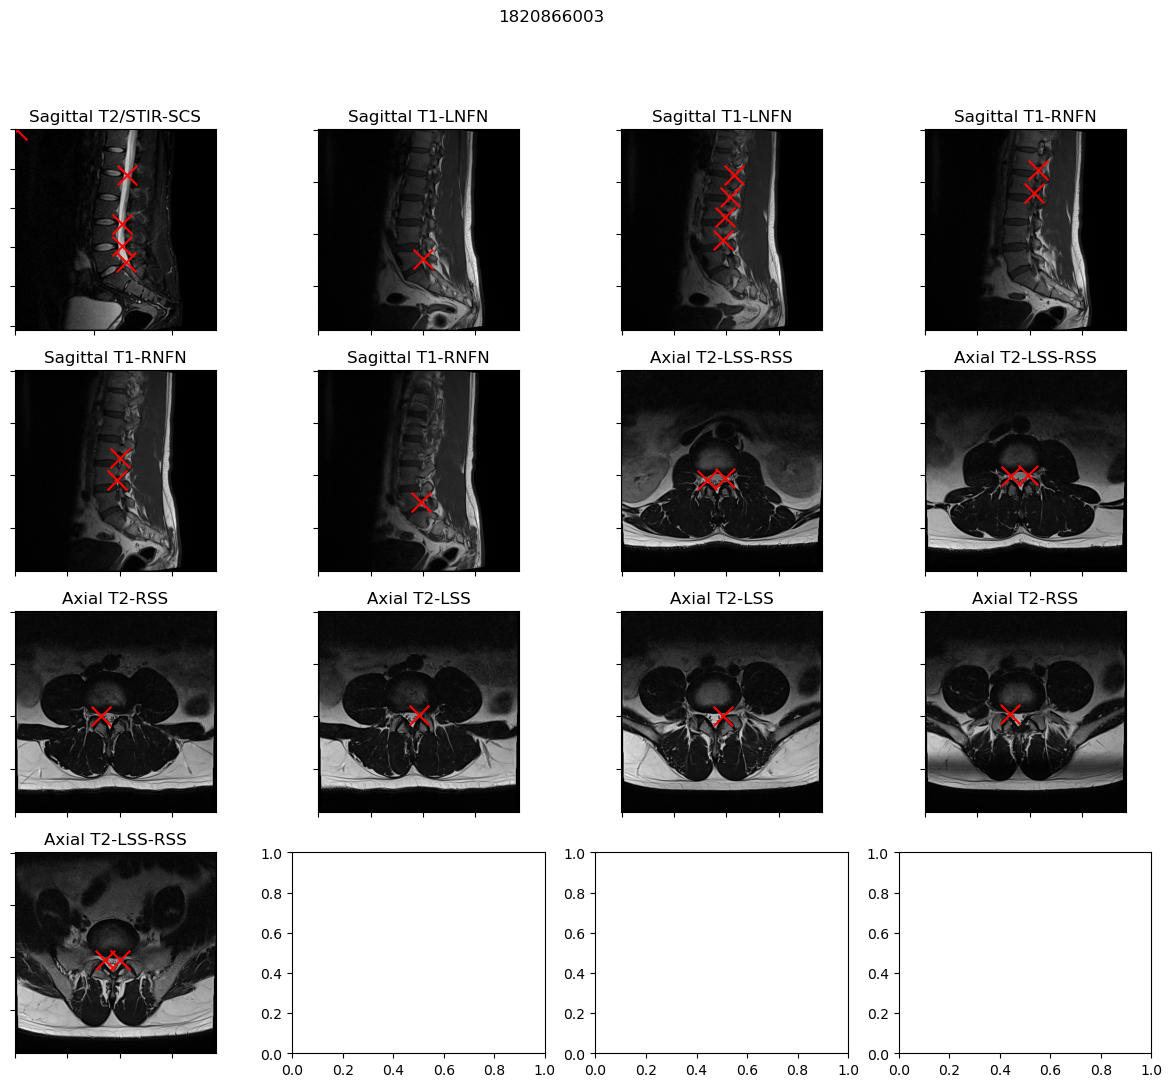

In [18]:
plot_conditions(1820866003)

#### Plot min x,y labels

In [19]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

bad_labels = coords_df[coords_df['x_perc'] < 0.15].study_id.tolist()

bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

print(row.study_id)

# plot(row)
plot_conditions(row.study_id)

3819260179


In [20]:
coords_df[coords_df['x'] < 10].shape, coords_df[coords_df['y'] < 10].shape

((13, 18), (13, 18))

#### Plot max x,y labels

3819260179


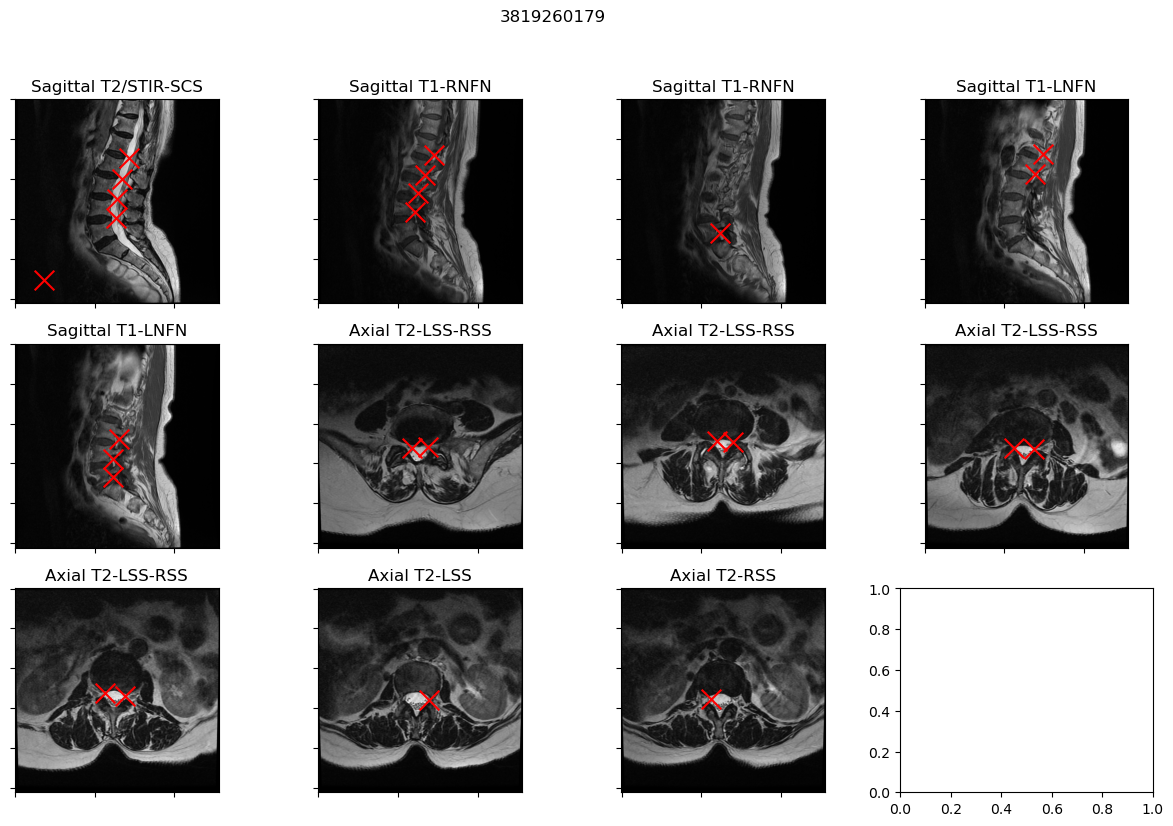

In [21]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

# bad_labels = [3819260179]

# bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

print(row.study_id)

# plot(row)
plot_conditions(row.study_id)

In [22]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

bad_labels = [3819260179, 2444340715]

# bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

# plot(row)
plot_conditions(row.study_id)

### Left/Right orientation plot

In [23]:
hfs = files_df[files_df['patientposition'] == 'HFS'].sample(1).study_id.values[0]
ffs = files_df[files_df['patientposition'] == 'FFS'].sample(1).study_id.values[0]

hfs, ffs

(2637411510, 434249980)

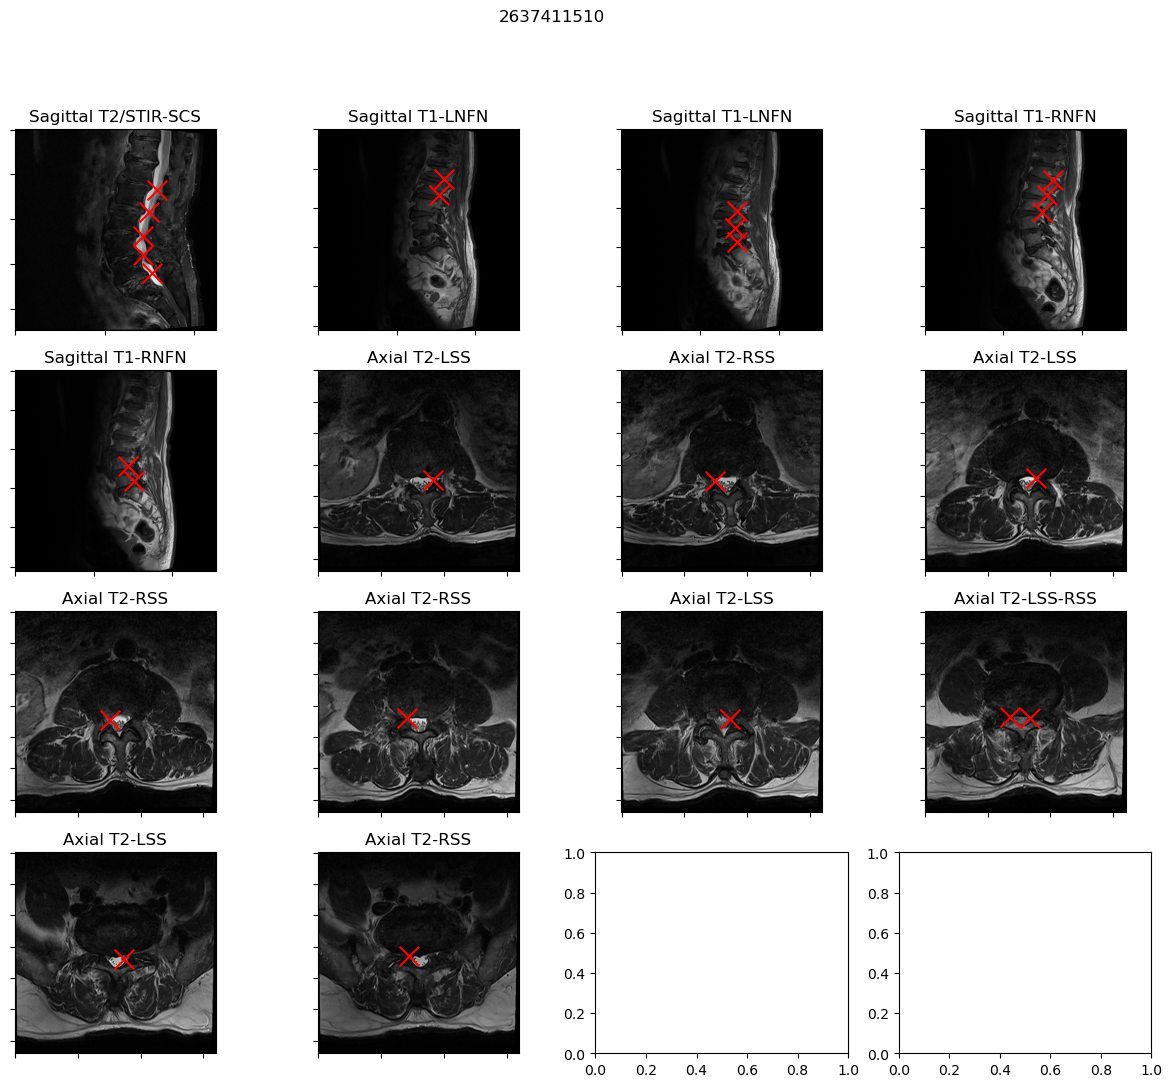

In [24]:
plot_conditions(hfs)

In [25]:
plot_conditions(ffs)

### Right/left orientation

In [26]:
# https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification/discussion/523859

#### RSS/LSS

In [27]:
cond = 'RSS'
selection = coords_df[coords_df['condition'] == cond]

selection.x_perc.hist(bins=200)

<Axes: >

In [56]:
# cond = 'RSS'
# selection = coords_df[(coords_df['condition'].isin(['LSS', 'RSS']))]

# selection.x_perc.hist(bins=200)

<Axes: >

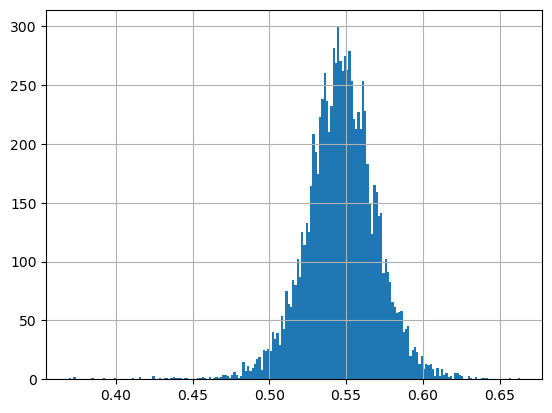

In [28]:
cond = 'LSS'
selection = coords_df[coords_df['condition'] == cond]

selection.x_perc.hist(bins=200)

In [58]:
cond = 'LSS'
selection = coords_df[(coords_df['condition'] == cond) & (coords_df['patientposition'] == 'FFS')]

selection.x_perc.hist(bins=200)

<Axes: >

<Axes: >

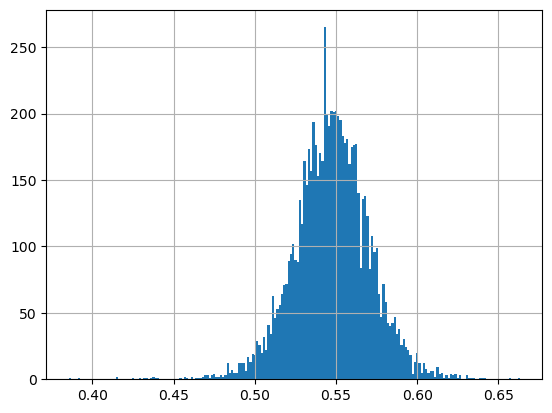

In [59]:
cond = 'LSS'
selection = coords_df[(coords_df['condition'] == cond) & (coords_df['patientposition'] == 'HFS')]

selection.x_perc.hist(bins=200)

In [62]:
cond = 'LSS'
selection = coords_df[coords_df['condition'] == cond]

selection.patientposition.value_counts()

patientposition
HFS    7673
FFS    1935
Name: count, dtype: int64

In [67]:
files_df.groupby(['study_id']).patientposition.unique().value_counts()

patientposition
[HFS]    1585
[FFS]     390
Name: count, dtype: int64

In [30]:
selection[selection['x_perc'] > 0.50].patientposition.value_counts()

patientposition
HFS    7489
FFS    1872
Name: count, dtype: int64

In [31]:
selection[selection['x_perc'] < 0.45].patientposition.value_counts()

patientposition
HFS    13
FFS    10
Name: count, dtype: int64

In [32]:
selection[selection['x_perc'] < 0.45].patientposition.value_counts()

patientposition
HFS    13
FFS    10
Name: count, dtype: int64

In [33]:
selection[selection['x_perc'] < 0.45].study_id.unique()

array([ 391103067,  677672203,  757619082, 1406734395, 1647904243,
       1670838975, 2399492744, 3495818564, 3945605592, 4072191052],
      dtype=int64)

### Frame position distribution in series

#### RNFN/LNFN

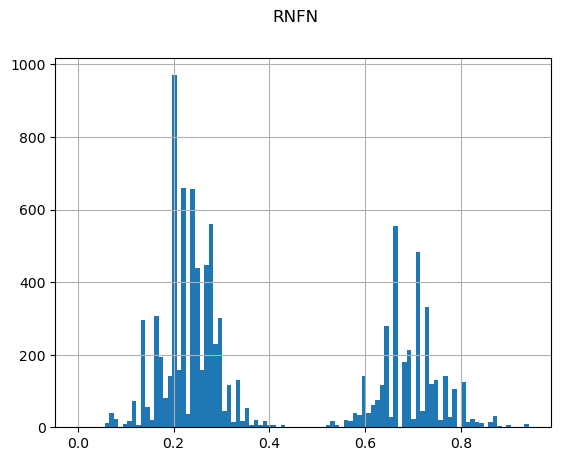

In [42]:
cond = 'RNFN'
selection = coords_df[coords_df['condition'] == cond]

selection.inst_perc.hist(bins=100)
plt.suptitle(cond)
plt.show()

In [43]:
cond = 'RNFN'
selection = coords_df[(coords_df['condition'] == cond) & (coords_df['patientposition'] == 'FFS')]

selection.inst_perc.hist(bins=200)
plt.suptitle(cond)
plt.show()

In [44]:
cond = 'RNFN'
selection = coords_df[(coords_df['condition'] == cond) & (coords_df['patientposition'] == 'HFS')]

selection.inst_perc.hist(bins=200)
plt.suptitle(cond)
plt.show()

In [45]:
cond = 'LNFN'
selection = coords_df[coords_df['condition'] == cond]

selection.inst_perc.hist(bins=100)
plt.suptitle(cond)
plt.show()

In [48]:
selection = coords_df[coords_df['patientposition'] == 'HFS']
selection.inst_perc = 1 - selection.inst_perc

C:\Users\Asus\AppData\Local\Temp\ipykernel_36144\1541673495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.inst_perc = 1 - selection.inst_perc


In [50]:
cond = 'LNFN'
selection = coords_df[coords_df['condition'] == cond]

# selection[selection['patientposition'] == 'HFS']['inst_perc'] = 1 - selection['inst_perc']

selection[selection['patientposition'] == 'HFS'].inst_perc.hist(bins=100)
plt.suptitle(cond)
plt.show()

#### SCS

In [47]:
cond = 'SCS'
selection = coords_df[coords_df['condition'] == cond]

selection.inst_perc.hist(bins=50)
plt.suptitle(cond)
plt.show()

In [46]:
selection.inst_perc.mean()

0.46975583086848616

### Sagital ordering

In [47]:
hfs = files_df[files_df['patientposition'] == 'HFS'].sample(1).study_id.values[0]
ffs = files_df[files_df['patientposition'] == 'FFS'].sample(1).study_id.values[0]

hfs, ffs

(2080571489, 3759970625)